# Activations recorded

## Prep Functions- show images

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np
from time import time
from torch.utils.data import Dataset

In [3]:
def plot_accuracy_loss(training_results):
    plt.subplot(2, 1, 1)
    plt.plot(training_results['training_loss'], 'r')
    plt.ylabel('loss')
    plt.title('training loss iterations')
    plt.subplot(2, 1, 2)
    plt.plot(training_results['validation_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.show()

def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))
    plt.show()

def show_dataComp(data_sample,y):
    plt.subplot(1,2,1)
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(data_sample[1].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = ' + str(y))

    plt.show()

## Img Pairing and Data Prep

1) traindataComp-trainloader: consecutive data pairs from the training set <br>
2) valdataComp-valloader: consecutive data pairs from the test set <br>
3) testdata- testloader: all data pairs from test set- keeps track of the pair <br>

In [4]:
def indlist(target):
    indlist = [[],[],[],[],[]]
    
    for i in range(len(target)):
        if target[i] < 5:
            indlist[target[i]].append(i)
    return indlist

def subData(dataSet):
    #gets all the indices of the data obsv with same y from the dataset that is passed in only for 0-4
    indices = indlist(dataSet.targets)
    # a list of datasets where each dataset has the data for the same number
    subsets = []
    [subsets.append(torch.utils.data.Subset(dataSet, i)) for i in indices]
    return subsets
    

In [5]:
def comparisonDataConsecutive(dataSet):
    subsets = subData(dataSet)
    # a list of the size of the possible pairs
    comp = []
    for indi in range(len(subsets) - 1):
        comp.append(int(min(len(subsets[indi]), len(subsets[indi + 1]))))
    tot1 = sum(comp)
    # img pair data stored
    x = torch.zeros([tot1, 2, 28, 28], dtype=torch.float32)
    # greater than or less than label stored
    y = torch.zeros([tot1,1])
    # 1 for first pic greater, 0 for first pic less
    k = 0
    # does the actual pairing
    for i in range(len(subsets) - 1):
        for j in range(int(comp[i] / 2)):
            x[k][0] = subsets[i][j][0]
            x[k][1] = subsets[i + 1][j][0]
            y[k][0] = 0
            k += 1
        for j in range(int(comp[i] / 2), comp[i]):
            x[k][1] = subsets[i][j][0]
            x[k][0] = subsets[i + 1][j][0]
            y[k][0] = 1
            k += 1
    return x,y/

In [6]:
def comparisonDataNonconsecutive(dataSet):
    subsets = subData(dataSet)
    # a dictionary of pairs and the size of the pairings
    comp = {}
    for i in range(len(subsets) - 2):
        for j in range(i + 2, len(subsets), 1):
            comp[(i, j)] = int(min(len(subsets[i]), len(subsets[j])))
    tot = sum(comp.values())
    # greater than or less than label stored
    x = torch.zeros([tot, 2, 28, 28], dtype=torch.float32)
    # 1 for first pic greater, 0 for first pic less
    y = torch.zeros([tot, 1])
    k = 0
    #the pairing
    for key, values in comp.items():
        for value in range(int(values / 2)):
            x[k][0] = subsets[key[0]][value][0]
            x[k][1] = subsets[key[1]][value][0]
            y[k][0] = 0
            k += 1
        for value in range(int(values / 2), values):
            x[k][0] = subsets[key[1]][value][0]
            x[k][1] = subsets[key[0]][value][0]
            y[k][0] = 1
            k += 1
    return x,y


In [42]:
def comparisonAll(dataSet):
    subsets = subData(dataSet)
    # a dictionary of pairs(tuple) and the size of the pairings
    comp = {}
    for i in range(len(subsets) - 2):
        for j in range(i + 1, len(subsets), 1):
            comp[(i, j)] = int(min(len(subsets[i]), len(subsets[j])))
    tot = sum(comp.values())
    # greater than or less than label stored
    x = torch.zeros([tot, 2, 28, 28], dtype=torch.float32)
    # 1 for first pic greater, 0 for first pic less
    y = torch.zeros([tot, 1])
    z = list()
    k = 0
    # the pairining
    for key, values in comp.items():
        for value in range(int(values / 2)):
            x[k][0] = subsets[key[0]][value][0]
            x[k][1] = subsets[key[1]][value][0]
            y[k][0] = 0
            z.append(key)
            k += 1
        for value in range(int(values / 2), values):
            x[k][0] = subsets[key[1]][value][0]
            x[k][1] = subsets[key[0]][value][0]
            y[k][0] = 1
            a = key[0]
            b = key[1]
            c = (b,a)
            z.append(c)
            k += 1
    return x,y,z

In [43]:
class Trainsetcomp(Dataset):
    def __init__(self, x, y):
        self.len = (x.shape[0])
        self.x = x
        self.y = y 

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return self.len

In [44]:
class TrainsetcompwithA(Dataset):
    def __init__(self, x, y, z):
        self.len = (x.shape[0])
        self.x = x
        self.y = y 
        #the pair
        self.z = z

    def __getitem__(self, index):
        return (self.x[index], self.y[index], self.z[index])

    def __len__(self):
        return self.len

In [45]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),])

trainset = dsets.MNIST(root='./../data',
                            train=True,
                            download=True,
                            transform=transform)
valset = dsets.MNIST(root='./../data',
                            train=False,
                            download=True,
                            transform=transform)

In [46]:
x, y = comparisonDataConsecutive(trainset)
traindataComp = Trainsetcomp(x,y)
x,y = comparisonDataConsecutive(valset)
valdataComp = Trainsetcomp(x,y)

In [47]:
trainloader = torch.utils.data.DataLoader(traindataComp,
                                          batch_size=64,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(valdataComp,
                                          batch_size=64,
                                          shuffle=True)
x,y,z = comparisonAll(valset)
testdata = TrainsetcompwithA(x,y,z)
testloader = torch.utils.data.DataLoader(testdata,
                                          batch_size=64,
                                          shuffle=F)
# in the test loader: z is a list of size 2 of two [64] shape tensors. - it turned the tuple into a list of tensors

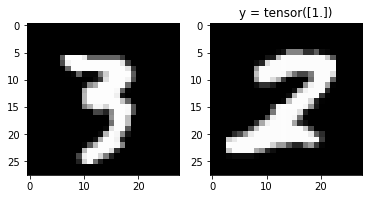

tensor(3) tensor(2)


In [54]:
## showing what the z in the test loader is- ignore
i = 1
j = 0
for x,y,z in testloader:
    j+=1
    p = x[i,:,:,:]
    show_dataComp(p,y[i,:])
    #print(z)
    print(z[0][i],z[1][i])
    if j >= 1:
        break

## Model

In [88]:
ind = 2 * 28 * 28
hiddendim = [400,200,64]
outd = 1
# 0 if first image is less than and 1 if frist image is greater than

In [96]:
class ModelFull(nn.Module):
    def __init__(self, ind,h1d,h2d,h3d,outd):
        super(ModelFull, self).__init__()
        self.lin1 = nn.Linear(ind, h1d)
        self.lin2 = nn.Linear(h1d, h2d)
        self.lin3 = nn.Linear(h2d, h3d)
        self.lin4 = nn.Linear(h3d, outd)
        self.activations = []
        self.pairs = []

    def forward(self, x, recActivations = False):
        if recActivations:
            x1 = torch.relu(self.lin1(x))
            x2 = torch.relu(self.lin2(x1))
            x3 = torch.relu(self.lin3(x2))
            self.activations.append(x3)
            x4 = torch.sigmoid(self.lin4(x3))
            return x4
        else:
            x1 = torch.relu(self.lin1(x))
            x2 = torch.relu(self.lin2(x1))
            x3 = torch.relu(self.lin3(x2))
            x4 = torch.sigmoid(self.lin4(x3))
            return x4
        
    def setPair(self, pair):
        self.pairs.append(pair)

In [97]:
def train(model, criterion, optimizer, epochs = 30):
    lossList = []
    #time0 = time()
    for i in range(epochs):
        runningLoss = 0
        for x, y in trainloader:
            optimizer.zero_grad()
            yhat = model(x.view(-1, 2 * 28 *28))
            #print(yhat.shape)
            #print(y.shape)
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()
            runningLoss += loss.item()
        print('epoch ', i, ' loss: ', str(runningLoss / len(traindataComp)))
        lossList.append(runningLoss / len(traindataComp))
    return lossList

In [98]:
model = ModelFull(ind,hiddendim[0],hiddendim[1],hiddendim[2], outd)

In [99]:
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.03)
results = train(model,criterion,optimizer,25)

epoch  0  loss:  0.008733639343116318
epoch  1  loss:  0.004051011978181742
epoch  2  loss:  0.002187853483837539
epoch  3  loss:  0.0016020586082779382
epoch  4  loss:  0.0011678018264181774
epoch  5  loss:  0.0010088350091189793
epoch  6  loss:  0.0008821851611956294
epoch  7  loss:  0.0007930122579911089
epoch  8  loss:  0.0006564705582842881
epoch  9  loss:  0.0006028631571634687
epoch  10  loss:  0.0014974820196506182
epoch  11  loss:  0.0006955977505238364
epoch  12  loss:  0.0004866103245524745
epoch  13  loss:  0.00092757672381085
epoch  14  loss:  0.000539636522171699
epoch  15  loss:  0.00042297771180736115
epoch  16  loss:  0.00031846098123743946
epoch  17  loss:  0.00023021138210282025
epoch  18  loss:  0.0002464844879236723
epoch  19  loss:  0.00025379385122594275
epoch  20  loss:  0.00013882958988714456
epoch  21  loss:  0.00010032881407654586
epoch  22  loss:  5.90960906863404e-05
epoch  23  loss:  0.0007765317970140342
epoch  24  loss:  0.001400851129518585


In [100]:
## Consecutive test set
totcount = 0
correctcount = 0
for x,y in valloader:
    x = x.view(-1, 2 * 28 *28)
    with torch.no_grad():
        yhat = model(x)
    #print(yhat.shape)
    ones = torch.ones(yhat.shape)
    yhat = torch.where(yhat>.9, ones, yhat)
    z = torch.zeros(yhat.shape)
    yhat = torch.where(yhat<0.1, z, yhat)
    for i,j in zip(yhat,y):
        if i[0] == j[0]:
            correctcount+=1
        totcount+=1
print(correctcount)
print(totcount)
#print(len(dataPairing.valdataComp))
print('valset accuracy: ', correctcount/totcount)

3802
4004
valset accuracy:  0.9495504495504495


In [101]:
## non consecutive test set
for x,y in valloader:
    x = x.view(-1, 2 * 28 *28)
    with torch.no_grad():
        yhat = model(x)
    ones = torch.ones(yhat.shape)
    yhat = torch.where(yhat>.5, ones, yhat)
    z = torch.zeros(yhat.shape)
    yhat = torch.where(yhat<0.5, z, yhat)
    wrongC = 0
    for i in range(len(y)):
        #print(i)
        if yhat[i][0] == y[i][0]:
            correctcount+=1
            #p = torch.reshape(x[i], (2,28,28))
            #show_dataComp(p, y[i])
            
        else:
            #if wrongC < 2:
                #p = torch.reshape(x[i], (2,28,28))
                #show_dataComp(p, yhat[i])
            wrongC += 1
        totcount+=1
print(correctcount)
print(totcount)
print('test set accuracy: ', correctcount/totcount)

7714
8008
test set accuracy:  0.9632867132867133


In [102]:
## test data set where activations are recorded

for x,y,z in testloader:
    x = x.view(-1, 2 * 28 *28)
    with torch.no_grad():
        yhat = model(x,True)
    model.setPair(z)
    ones = torch.ones(yhat.shape)
    yhat = torch.where(yhat>.5, ones, yhat)
    z = torch.zeros(yhat.shape)
    yhat = torch.where(yhat<0.5, z, yhat)
    wrongC = 0
    for i in range(len(y)):
        #print(i)
        if yhat[i][0] == y[i][0]:
            correctcount+=1
            #p = torch.reshape(x[i], (2,28,28))
            #show_dataComp(p, y[i])
            
        else:
            #if wrongC < 2:
                #p = torch.reshape(x[i], (2,28,28))
                #show_dataComp(p, yhat[i])
            wrongC += 1
        totcount+=1
print(correctcount)
print(totcount)
print('test set accuracy: ', correctcount/totcount)

16126
16944
test set accuracy:  0.9517233238904627


In [107]:
len(testdata)
print(len(testloader))
print(model.activations[0].shape)
print(len(model.pairs))
print(model.pairs[0][1].shape)
print(model.activations[0])

140
torch.Size([64, 64])
140
torch.Size([64])
tensor([[0.3978, 0.2578, 0.8092,  ..., 0.3629, 0.0000, 0.0000],
        [0.0000, 0.8148, 2.9453,  ..., 1.5833, 0.0374, 0.0000],
        [0.0000, 0.5649, 2.2676,  ..., 1.2280, 0.0095, 0.0000],
        ...,
        [0.0000, 0.5782, 1.9103,  ..., 0.8929, 0.0000, 0.0000],
        [1.5552, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1036, 0.3663, 1.1732,  ..., 0.5707, 0.0036, 0.0000]])


## RSA preprocess

In [114]:
# incomplete
for pair,activ in zip(model.pairs, model.activations):
    for i in range(len(pair[0])):
        p1= pair[0][i].item()
        p2 = pair[1][i].item()
        t = (p1,p2)
        print(t)
        break
    break

(1, 3)
